In [50]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tag.util import untag
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn.model_selection import KFold
import numpy as np, pandas as pd

In [51]:
def load_data(files):
    data, sent = [], []
    for file in files:
        with open(file, 'r', encoding="utf-8") as rf:
            for line in rf:
                if line.strip() != '':
                    # Note: the shared corpus is already tokenized
                    sent.append(line.strip().split('\t'))
                else:
                    if len(sent) > 0:
                        data.append(sent)
                        sent = []
    return data

# sentences = load_data(["data/BN_EN_TRAIN_2015.txt"])
sentences = load_data(['data/FB_BN_EN_FN.txt', 'data/TWT_BN_EN_FN.txt',"data/BN_EN_TRAIN_2015.txt"])
# sentences = load_data(['data/FB_BN_EN_FN.txt', 'data/TWT_BN_EN_FN.txt','data/WA_BN_EN_FN.txt',"data/BN_EN_TRAIN_2015.txt"])

## LID on old 2015 data

In [52]:
new_sentences = []
for line in sentences:
    sent = []
    for word_lang_pos in line:
        sent.append([word_lang_pos[0],word_lang_pos[1]])
    new_sentences.append(sent)

In [53]:
len(new_sentences)

3157

In [54]:
len(new_sentences)

3157

### for EDA

In [55]:
sentences[0][:4]

[['fake', 'en', 'JJ'],
 ['holeo', 'bn', 'N_NNP'],
 ['proposal', 'en', 'N_NN'],
 ['pay', 'bn', 'V_VM']]

In [56]:
sent_word = []
sent_lang = []
sent_pos = []

for line in sentences:
    lang = []
    word = []
    pos = []
    for word_lang_pos in line:
        word.append((word_lang_pos[0]))
        lang.append(word_lang_pos[1])
        pos.append(word_lang_pos[2])
    sent_word.append(word)
    sent_lang.append(lang)
    sent_pos.append(pos)

In [57]:
sent_word[-1]

['bcz',
 'gf',
 'tao',
 'tar',
 'kache',
 '1ta',
 'show',
 'off',
 'er',
 'e',
 'object',
 '.']

In [58]:
import itertools
flat_df = pd.DataFrame({"word":list(itertools.chain(*sent_word)),"lang":list(itertools.chain(*sent_lang)),
                        "pos":list(itertools.chain(*sent_pos))})

In [59]:
flat_df.lang.value_counts(normalize = True)

bn                0.384777
en                0.368452
univ              0.186979
ne                0.028345
hi                0.018729
acro              0.008582
undef             0.002432
ne+bn_suffix      0.000867
en+bn_suffix      0.000475
ne+en_suffix      0.000168
acro+en_suffix    0.000084
univ..            0.000028
:D                0.000028
acro+bn_suffix    0.000028
mixed             0.000028
Name: lang, dtype: float64

In [60]:
flat_df.shape

(35774, 3)

In [61]:
# flat_df.to_csv("en-bn_word_distribution.csv",index=False, columns=flat_df.columns)

In [62]:
def pun_bool(word):
    sum = False
    if "!" in word:
        sum = True
    if "@" in word:
        sum = True
    if "#" in word:
        sum = True
    if "$" in word:
        sum = True
    if "%" in word:
        sum = True
    if "&" in word:
        sum = True
    if "*" in word:
        sum = True
    if "-" in word:
        sum = True
    if "_" in word:
        sum = True
    if "+" in word:
        sum = True
    if "|" in word:
        sum = True
    if ":" in word:
        sum = True
    if ";" in word:
        sum = True
    if "<" in word:
        sum = True
    if ">" in word:
        sum = True    
    if "?" in word:
        sum = True
    if "," in word:
        sum = True
    if "/" in word:
        sum = True
    return sum

In [63]:
def feature_extractor(sentence,index):
        return {
          'word': sentence[index].lower(),
#            'is_first': index == 0,
#            'is_last': index == len(sentence) - 1,
#            'is_capitalized': sentence[index][0].upper() == sentence[index][0],
          'is_all_caps': sentence[index].upper() == sentence[index],
#          'is_all_lower': sentence[index].lower() == sentence[index],
         'prefix-1': sentence[index][0],
         'prefix-2': sentence[index][:2],
         'prefix-3': sentence[index][:3],
         'suffix-1': sentence[index][-1],
         'suffix-2': sentence[index][-2:],
         'suffix-3': sentence[index][-3:],
         'suffix-4': sentence[index][-4:],
#           "is_3_len" : 1 if len(sentence[index])==3 else 0,
          "is_2_len" : 1 if len(sentence[index])==2 else 0,
          "prev_word_istitle":1 if index==1 else 0,
#          "next_word_eos": 1 if index == len(sentence)-2 else 0,
#          'prev_word': '' if index == 0 else sentence[index - 1],
#          'prev2_word': '' if index <2 else sentence[index - 2],
#          'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
            "has_pun" : pun_bool(sentence[index]),
#           'is_numeric': sentence[index].isdigit(),
           'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
#             "first_@": 1 if sentence[index][0]=="@" else 0
#           "next_to":"" if index > len(sentence)-2 else sentence[index+1] == "to",
#          "last_to": "" if index==0 else sentence[index-1] == "to",
#           "next_in":"" if index > len(sentence)-2 else sentence[index+1] == "in"         
        }

In [64]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        X.append([feature_extractor(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])
    return X, y

In [65]:
all_sentences = np.array(new_sentences.copy())

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import itertools

In [67]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)

accuracy = []

for train_index, test_index in kfold.split(all_sentences):
    
    X_train, y_train = transform_to_dataset(all_sentences[train_index])
    X_test, y_test = transform_to_dataset(all_sentences[test_index])
    
    model = CRF(c1 = 1.0, c2 = 0.001, max_iterations = 100)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy.append(accuracy_score(list(itertools.chain(*y_test)),list(itertools.chain(*y_pred)))) 
    
print("average accuracy : ",np.round(np.mean(accuracy)*100,2),"%")

average accuracy :  94.01 %


#### test-train split

In [68]:
X,y = transform_to_dataset(all_sentences)

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state = 7)

In [70]:
model = CRF(c1 = 1.0, c2 = 0.001, max_iterations = 100)
model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)

In [71]:
metrics.flat_accuracy_score(y_test,y_pred)

0.9337145524565293

In [72]:
metrics.flat_f1_score(y_test,y_pred,average = "micro")

0.9337145524565293

In [73]:
metrics.flat_f1_score(y_test,y_pred,average = "macro")

0.5521909705621793

In [74]:
metrics.flat_classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n        acro       0.79      0.72      0.75        68\n          bn       0.92      0.96      0.94      3238\n          en       0.94      0.95      0.95      3115\nen+bn_suffix       0.00      0.00      0.00         3\n          hi       0.81      0.54      0.65       191\n          ne       0.68      0.49      0.57       257\nne+bn_suffix       1.00      0.23      0.38        13\nne+en_suffix       0.00      0.00      0.00         3\n       undef       0.67      0.20      0.31        10\n        univ       0.99      0.98      0.98      1671\n\n    accuracy                           0.93      8569\n   macro avg       0.68      0.51      0.55      8569\nweighted avg       0.93      0.93      0.93      8569\n'

In [75]:
import matplotlib.pyplot as plt
import scikitplot as skplt

<Figure size 720x720 with 0 Axes>

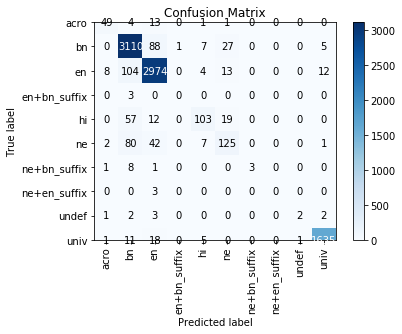

In [76]:
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(list(itertools.chain(*y_test)),list(itertools.chain(*y_pred)),x_tick_rotation=90)

              precision    recall  f1-score   support

        acro       0.79      0.72      0.75        68
          bn       0.92      0.96      0.94      3238
          en       0.94      0.95      0.95      3115
en+bn_suffix       0.00      0.00      0.00         3
          hi       0.81      0.54      0.65       191
          ne       0.68      0.49      0.57       257
ne+bn_suffix       1.00      0.23      0.38        13
ne+en_suffix       0.00      0.00      0.00         3
       undef       0.67      0.20      0.31        10
        univ       0.99      0.98      0.98      1671

    accuracy                           0.93      8569
   macro avg       0.68      0.51      0.55      8569
weighted avg       0.93      0.93      0.93      8569

### model fitiing on whole dataset (feature weights analysis)

In [77]:
X,y = transform_to_dataset(all_sentences)

In [78]:
len(X)
len(y)

3157

In [79]:
model = CRF(c1 = 1.0, c2 = 0.001, max_iterations = 100)
model.fit(X, y)

CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=1.0, c2=0.001, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [80]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(model.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(model.transition_features_).most_common()[-20:])

Top likely transitions:
undef  -> undef   5.559163
hi     -> hi      5.264731
en     -> en      3.705426
ne     -> ne      3.640912
bn     -> bn      3.543661
en     -> ne      2.876932
bn     -> ne      2.529209
en     -> bn      2.503831
en     -> acro    2.280815
bn     -> en      2.155849
bn     -> en+bn_suffix 2.096116
en     -> univ    1.916768
en     -> hi      1.795837
bn     -> univ    1.791404
bn     -> acro    1.763037
en+bn_suffix -> acro    1.674388
hi     -> ne      1.672145
en     -> undef   1.548265
ne     -> bn      1.504479
acro   -> acro    1.417935

Top unlikely transitions:
hi     -> acro    1.097018
ne     -> hi      1.078258
bn     -> ne+bn_suffix 1.021963
acro   -> ne      0.933175
univ   -> undef   0.928165
ne+bn_suffix -> bn      0.868343
univ   -> hi      0.864531
ne     -> univ    0.737516
univ   -> univ    0.709203
acro   -> univ    0.544035
univ   -> acro    0.536245
undef  -> en      0.407411
bn     -> undef   0.363321
ne     -> acro    0.297883
bn     ->

In [81]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(model.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(model.state_features_).most_common()[-30:])

Top positive:
9.290270 univ     prefix-1:@
6.839057 univ     prefix-1:.
6.791588 acro     word:etce
6.685525 univ     suffix-2:ww
6.421132 univ     prefix-1:#
6.122117 en       word:no
5.565204 en       word:so
5.475699 en       suffix-3:ion
5.415016 bn       word:expectation
5.411114 en+bn_suffix prefix-3:mob
5.395841 en       word:the
5.386834 acro     word:asi
5.310798 bn       word:er
5.274639 ne       suffix-2:SR
5.165582 ne       word:yd
5.146617 acro     suffix-2:gl
4.930738 en       suffix-3:ear
4.841269 en       suffix-2:ck
4.809448 en       suffix-2:ic
4.809433 acro     word:dslr
4.776924 acro     word:fb
4.708827 acro     prefix-3:FET
4.690297 univ     word:wow
4.689461 acro     suffix-3:bps
4.599920 en       word:u
4.458222 en       word:she
4.456821 ne       suffix-4:rjee
4.414854 en       prefix-3:adm
4.397067 univ     is_all_caps
4.393188 univ     prefix-1:'

Top negative:
-1.455749 bn       prefix-1:w
-1.456525 bn       suffix-4:star
-1.473691 en       suffix-3:ire
-1.4